## Plot results of training of a SVDTime Neural Network

This notebook displays the results of time fits for digit produced by the SVD digitizer.
The digits are collected using the SVDFitDigitsModule, and its output is imported and shown here. 

##### Required Python packages

The following python packages are used:
- math (basic python math functions)
- numpy (Vectors and matrices for numerics)
- pandas (Python analogue of Excel tables)
- matplotlib (Plotting library)
- seaborn (Advanced plotting)
- scipy (Scientific computing package)
- scikit-learn (machine learning)

If you get an error message complaining about a missing package, do

pip3 install *_package name_*

##### Other pre-requisites:

A sample of training data, plus binning and bounds information in pickle (*.pkl) files.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats as stats
from scipy.optimize import minimize_scalar
from svd.SVDSimBase import *

Welcome to JupyROOT 6.08/06


### Retrieve dumped digit fits

In [2]:
digit_fit_filename = '/media/sf_MateShare/kvasnicka/tb2017/output/dumped_tb_digits.txt'

digits = pd.read_csv(digit_fit_filename, index_col = False, delim_whitespace = True)

pkl_name = 'SVDTime_TrainingBins_1000000.pkl'
bins = pd.read_pickle(pkl_name)

timearray = bins['midpoint']
timebins = np.unique(bins[['lower','upper']])

In [3]:
digits.head()

,EventNo,Layer,Ladder,Sensor,Side,StripNo,TimeTrigger,GoodStrip,Gain,Noise,...,TimeShift,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Charge,TimeFit,Chi2
0,14,3,1,2,u,287,-11.79,y,328.413,1051.319,...,96.414,3.0,16.0,40.0,42.0,36.0,27.0,16246.468,-24.204,1.538
1,14,3,1,2,u,288,-11.79,y,328.020,1066.836,...,92.989,0.0,13.0,33.0,34.0,23.0,16.0,12151.880,-26.941,1.382
2,14,3,1,2,u,375,-11.79,y,308.901,1132.497,...,92.205,1.0,42.0,109.0,109.0,86.0,63.0,41406.969,-26.044,4.008
3,14,3,1,2,u,397,-11.79,y,317.472,964.853,...,93.986,0.0,15.0,40.0,41.0,28.0,25.0,15118.291,-25.229,1.578
4,14,3,1,2,u,439,-11.79,y,317.114,1038.880,...,94.985,6.0,14.0,33.0,34.0,30.0,20.0,13214.970,-25.026,1.198


We add a random column for sampling. We set the value to negative for rows we want to exclude from sampling. First thhing we exclude bad strips from consideration.

Index(['EventNo', 'Layer', 'Ladder', 'Sensor', 'Side', 'StripNo',
       'TimeTrigger', 'GoodStrip', 'Gain', 'Noise', 'Width', 'TimeShift',
       'Sample0', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5',
       'Charge', 'TimeFit', 'Chi2', 'Test'],
      dtype='object')

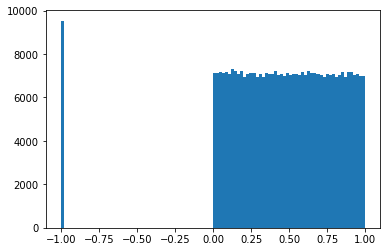

In [4]:
digits['Test'] = np.random.uniform(0.0,1.0,len(digits))
digits['Test'] = digits.apply(lambda row: row.Test if row.GoodStrip == 'y' else -1, axis = 1)
plt.hist(digits.Test, bins = 100);
digits.columns

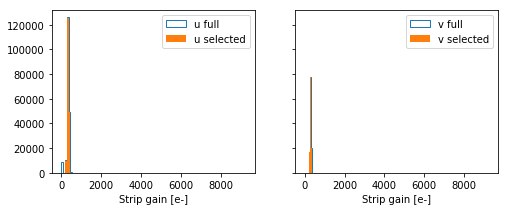

In [5]:
gain_low = 250
gain_high = 500
digits.Test = digits.apply(lambda row: row.Test if (row.Gain > gain_low and row.Gain < gain_high) else -1.0, axis = 1)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Gain[digits.Side==side], histtype = 'step', bins = 100, label = side + ' full');
    ax[i].hist(digits.Gain[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Strip gain [e-]')
plt.savefig('Gain_selection.png')

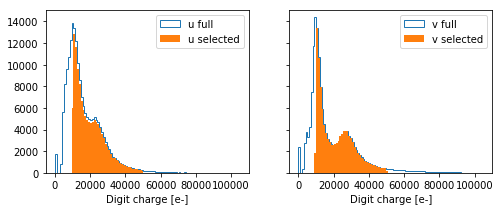

In [6]:
amplitude_low = 10000
amplitude_high = 50000
digits.Test = digits.apply(lambda row: row.Test if (row.Charge > amplitude_low and row.Charge < amplitude_high) else -1.0, axis = 1)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Charge[digits.Side==side], histtype = 'step', bins = 100, label = side + ' full');
    ax[i].hist(digits.Charge[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Digit charge [e-]')
plt.savefig('Amplitude_selection.png')

Now we also exclude data with extremely bad fits.

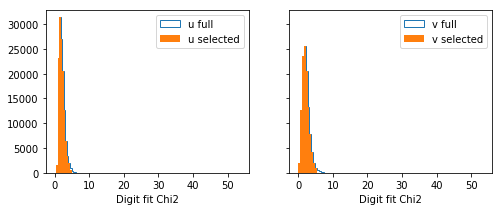

In [7]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Chi2[np.logical_and(digits.Side==side, digits.Test > 0.0)], histtype = 'step', bins = 100, label = side + ' full');
    max_chi2 = np.percentile(digits.Chi2[np.logical_and(digits.Side==side, digits.Test>0.0)], [99])[0]
    digits.Test = digits.apply(lambda row: row.Test if row.Side != side or row.Chi2 < max_chi2 else -1.0, axis = 1)
    ax[i].hist(digits.Chi2[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Digit fit Chi2')
plt.savefig('Chi2_selection.png')

Load the classifier

In [8]:
import pickle
with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
# the sample size of the network we want to use
n_samples = 1000000
pkl_name = 'SVDTime_Training{0}_{1}.pkl'

bounds = pd.read_pickle(pkl_name.format('Bounds', n_samples))

amp_range = (
    bounds.loc[bounds.value == 'amplitude','low'].values[0],
    bounds.loc[bounds.value == 'amplitude','high'].values[0]
)
tau_range =(
    bounds.loc[bounds.value == 'tau','low'].values[0],
    bounds.loc[bounds.value == 'tau','high'].values[0]
)
coder = tau_encoder(amp_range, tau_range)


Function to calculate amplitude, time and chi2 from samples and pdf

In [9]:
def fitFromProb(fw, signals, p, tau, timearray):
    t_fit = np.average(timearray, weights = p)
    t_sigma = np.sqrt(np.average((timearray - t_fit)**2, weights = p))
    weights = fw(-t_fit + np.linspace(-dt, 4*dt, 6, endpoint = True), tau = tau)
    weights[signals == 0.0] = 0.0
    norm = 1.0 / np.inner(weights, weights)
    a_fit = np.inner(signals, weights) * norm
    a_sigma = np.sqrt(norm)
    residuals = signals - a_fit * weights
    ndf = np.sum(np.ones_like(signals[signals>0])) - 2 # Can't be less than 1
    chi2_ndf = np.inner(residuals, residuals)/ndf
    return pd.Series({
        't_fit':t_fit, 
        't_sigma':t_sigma, 
        'a_fit':a_fit, 
        'a_sigma':a_sigma,
        'chi2_ndf':chi2_ndf,
        'res0':residuals[0],
        'res1':residuals[1],
        'res2':residuals[2],
        'res3':residuals[3],
        'res4':residuals[4],
        'res5':residuals[5]
            })

### Reconstruct waveforms

Histogram fit residuals

In [32]:
import ROOT
from ROOT import TProfile, TCanvas
%jsroot on

In [84]:
dtau_all = 10
sample_size = 10000

def row_residuals(row, dtau = 0.0, profile = None):
    x = np.zeros(7)
    x[0:6] = row[['Sample{0}'.format(i) for i in range(6)]]
    noise_adu = row.Noise/row.Gain if row.Gain > 0 else 1.0
    x[0:6] = x[0:6]/noise_adu
    tau = row.Width + dtau
    x[6] = coder.encode(tau)
    p = classifier.predict_proba(x.reshape(1,-1))
    fit_result = fitFromProb(betaprime_wave, x[0:6], p[0], tau, timearray)
    residuals = list(fit_result[['res' + str(i) for i in range(6)]])
    t = list(-fit_result['t_fit'] + np.linspace(-dt, 4*dt, 6, endpoint = True))
    wt = 6 * [1.0/fit_result['t_sigma'] if fit_result['t_sigma'] > 0 else 0.0]
    for i in range(len(t)):
        profile.Fill(t[i], residuals[i], wt[i])
    return fit_result['chi2_ndf']

hProf = [
    ROOT.TProfile("hProf_u", "Waveform residuals u", 25,-50.0,200.0, -4.0, 4.0, 's'),
    ROOT.TProfile("hProf_v", "Waveform residuals v", 25,-50.0,200.0, -4.0, 4.0, 's')
]

for side, i in zip(['u', 'v'], range(2)):
    sample = digits[np.logical_and(digits.Side == side, digits.Test > 0.0)].sample(n=sample_size)
    chis = sample.apply(row_residuals, dtau = dtau_all, profile = hProf[i], axis = 1)
    print('Side: {0} Length of data: {1}'.format(side, hProf[i].GetEntries()))

can = ROOT.TCanvas('c'+side, 'Waveform residuals', 800,300)
can.Divide(2,1)
can.cd(1)
hProf[0].Draw()
hProf[0].SetLineColor(ROOT.kRed)
hProf[0].GetYaxis().SetRangeUser(-4,4)
can.cd(2)
hProf[1].Draw()
hProf[1].SetLineColor(ROOT.kRed)
hProf[1].GetYaxis().SetRangeUser(-4,4)
can.Draw()
picname = 'Residuals_dtau'+ str(dtau_all) + '.png'
can.SaveAs(picname)


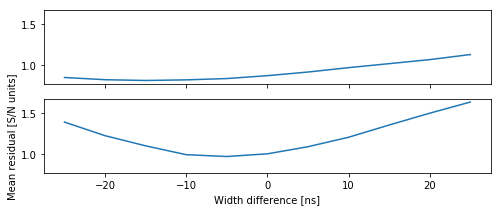

In [82]:
stats = np.zeros(10)
dtaus = np.linspace(-25,25,11, endpoint = True)
errors = np.zeros([2,len(dtaus)])
for dtau_iter,j in zip(dtaus, range(len(dtaus))):
    for side, i in zip(['u', 'v'], range(2)):
        sample = digits[np.logical_and(digits.Side == side, digits.Test > 0.0)].sample(n=sample_size)
        chis = sample.apply(row_residuals, dtau = dtau_iter, profile = hProf[i], axis = 1)
        hProf[i].GetStats(stats)
        errors[i,j] = np.sqrt(stats[5]/stats[0])
        print('Side: {0} Error: {1}'.format(side, errors[i,j]))
        hProf[i].Reset()

fig, ax = plt.subplots(2,1,sharex = True, sharey = True, figsize = (8,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].plot(dtaus, errors[i,:], label = side)
    
plt.xlabel('Width difference [ns]')
plt.ylabel('Mean residual [S/N units]')
plt.savefig('Waveform_errors.png')

In [77]:
np.sqrt(stats[5]/stats[0])

1.0756408206794654